# StroopActFlow -- Computational Model -- Single Subject

## Goal: Try to non-linear FC processes by estimating and extracting out the B0 term from multiple linear regression
### Idea: Using a simple dynamical model with a non-linearity (e.g., tanh, sigmoid, rectified linear unit) we can extract the bias term in the model for each node by estimating the B0 from multiple linear regression

#### Taku Ito
#### 01/26/2016

### Generate a simple model with no network structure with all excitatory connections


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import sys
import fc
% matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm
from matplotlib.backends.backend_pdf import PdfPages


# 0.0 Set up network
## 0.1 Construct artificial structural matrix

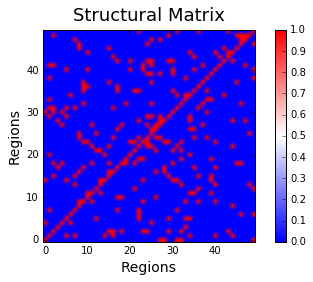

In [78]:
# Number of communities
ncommunities = 1
innetwork_dsity = .1
outnetwork_dsity = .1
hubnetwork_dsity = .1

nodespernetwork = 50
totalnodes = nodespernetwork * ncommunities

Wee = np.zeros((totalnodes,totalnodes))
# Construct structural matrix
nodecount = 0
for i in range(ncommunities):
    for j in range(ncommunities):
        for node in range(nodespernetwork):
            # Set within network community connections
            if i==j:
                tmp_a = np.random.rand(nodespernetwork,nodespernetwork)<innetwork_dsity
                indstart = i*nodespernetwork
                indend = i*nodespernetwork+nodespernetwork
                # Make connections lognormal
                Wee[indstart:indend,indstart:indend] = tmp_a
            else:
                tmp_b = np.random.rand(nodespernetwork,nodespernetwork)<outnetwork_dsity
                indstart_i = i*nodespernetwork
                indend_i = i*nodespernetwork + nodespernetwork
                indstart_j = j*nodespernetwork
                indend_j = j*nodespernetwork + nodespernetwork
                Wee[indstart_i:indend_i, indstart_j:indend_j] = tmp_b
                # Make symmetric across diagonal
#                 Wee[indstart_j:indend_j, indstart_i:indend_i] = tmp_b.T
                
# Redo a community to force it like a hub
hubnetwork = 0
for i in range(ncommunities):
    for j in range(ncommunities):
        if (i==hubnetwork or j==hubnetwork) and i!=j:
            tmp_b = np.random.rand(nodespernetwork,nodespernetwork)<hubnetwork_dsity
            indstart_i = i*nodespernetwork
            indend_i = i*nodespernetwork + nodespernetwork
            indstart_j = j*nodespernetwork
            indend_j = j*nodespernetwork + nodespernetwork
            Wee[indstart_i:indend_i, indstart_j:indend_j] = tmp_b
            # Make symmetric across diagonal
#             Wee[indstart_j:indend_j, indstart_i:indend_i] = tmp_b.T
        
# Make sure self-connections exist
np.fill_diagonal(Wee, 1)

fig = plt.figure()
plt.imshow(Wee, origin='lower',cmap='bwr')
plt.title('Structural Matrix', y=1.02, fontsize=18)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions',fontsize=14)
plt.tight_layout()
plt.colorbar()


## 0.2 Add Gaussian synaptic weights

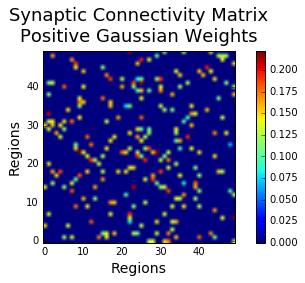

In [79]:
# Find non-zero connections
Gee = np.zeros((Wee.shape))
# triu = np.triu_indices(totalnodes,k=0)
connect_ind = np.where(Wee!=0)
nconnects = len(connect_ind[0])
# weights = np.random.lognormal(mean=1.0-np.log(0.2), sigma=1.0, size=(nconnects,))
weights = np.random.normal(loc=1.0,scale=0.2, size=(nconnects,))
Gee[connect_ind] = weights
# Gee[triu] = Wee[triu] * weights[triu]
# Now force lower triangle to have same weights
# Gee = Gee + Gee.T
# Now divide diagonal by 2, since it was added twice
# diag_ind = np.diag_indices(totalnodes)
# Gee[diag_ind] = Gee[diag_ind]/2.0

np.fill_diagonal(Gee,0)
Gee = Gee/np.sqrt(totalnodes)

# To avoid unrealistic connectivity strengths as in Teramae 2012 paper, let no Gee > 20
# while np.sum(Gee>20) > 0:
#     # Find where these synapses are
#     ind = np.where(Gee>20)
#     xrows = len(ind[0])
#     rand = np.random.randn(xrows,)
#     Gee[ind] = rand

fig = plt.figure()
plt.imshow(Gee, origin='lower')#, vmin=0, vmax=20)
plt.colorbar()
plt.title('Synaptic Connectivity Matrix\nPositive Gaussian Weights', y=1.02, fontsize=18)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions',fontsize=14)
plt.tight_layout()



# 1.0 The model

$$ \frac{dx_{i}}{dt} \tau_{i} = -x_{i}(t) + s \hspace{3 pt} \phi \hspace{1 pt} \bigg{(} x_i(t) + b_{i} \bigg{)} + g \bigg{(} \sum_{j\neq i}^{N} W_{ij} \hspace{3 pt} \phi \hspace{1 pt} \bigg{(} x_{j}(t) + b_{i} \bigg{)} \bigg{)}  + I_{j}(t)$$

where $x_i$ is the activity of region $i$, $\tau_{i}$ is the time constant for region $i$, $s$ is the recurrent (local) coupling, $g$ is the global coupling parameter, $\phi$ is the bounded transfer function (in this scenario is the hyperbolic tangent), $W_{xy}$ is the synaptic connectivity matrix, and $I$ is the task-stimulation (if any).

## 1.1 Define simulation function and associated functions
* relu function
* hrf and convolution functions

### 1.1.1 - rectified linear unit function

In [90]:
def relu(x):
    """rectified linear unit"""
    ind = np.where(x<0)[0]
    x[ind] = 0
    return x

### 1.1.2 - network model simulation

In [137]:
def networkModel(Tmax=100,dt=.1,g=3.0,s=1.0,tau=10.0,I=None, noise=None, bias=None, transfer='sigmoid'):
    """
    Tmax = 100      (1sec / 1000ms)
    dt = .1         (1ms)
    g = 3.0         Coupling 
    s = 1.0         Self connection
    tau = 1.0       Time constant 
    I = 0.0         Stimulation/Task
    
    
    """
    T = np.arange(0, Tmax, dt)

    # Select bias for each node
    if bias == None:
        bias = np.zeros((totalnodes,))
    
    # Select transfer function
    if transfer=='tanh':
        phi = lambda x: np.tanh(x)
    elif transfer=='sigmoid':
        phi = lambda x: 2/(1+np.exp(-2*x))
    elif transfer=='relu':
        def relu(x):
            """rectified linear unit"""
            ind = np.where(x<0)[0]
            x[ind] = 0
            return x
        phi = relu
    
    # External input (or task-evoked input) && noise input
    if I==None: I = np.zeros((totalnodes,len(T)))
    # Noise parameter
    if noise == None: noise = np.zeros((totalnodes,len(T)))
    if noise == 1: noise = np.random.normal(size=(totalnodes,len(T)))

    # Initial conditions and empty arrays
    Enodes = np.zeros((totalnodes,len(T)))
    # Initial conditions
    Einit = np.random.rand(totalnodes,)
    Enodes[:,0] = Einit

    spont_act = np.zeros((totalnodes,))
    for t in range(len(T)-1):

        ## Solve using Runge-Kutta Order 2 Method
        # With auto-correlation
        spont_act = (autocorrfactor*spont_act + noise[:,t] + I[:,t])
        k1e = -Enodes[:,t] + g*np.dot(Gee,phi(spont_act + bias)) # Coupling
        k1e += s*phi(Enodes[:,t] + bias) + spont_act# Local processing
        k1e = k1e/tau
        #   
        ave = Enodes[:,t] + k1e*dt
        #   
        # With auto-correlation
        spont_act = (autocorrfactor*spont_act + noise[:,t+1] + I[:,t+1])
        k2e = -ave + g*np.dot(Gee,phi(spont_act + bias)) # Coupling
        k2e += s*phi(ave + bias) + spont_act # Local processing
        k2e = k2e/tau

        Enodes[:,t+1] = Enodes[:,t] + (.5*(k1e+k2e))*dt

    plt.figure()
    plt.imshow(Enodes, origin='lower')
    plt.title('Activity')
    plt.ylabel('Regions')
    plt.xlabel('Time')
    plt.colorbar()

    plt.figure()
    plt.title('Activity of Sample Regions')
    for i in range(ncommunities):
        n = i * nodespernetwork
        plt.plot(Enodes[n,:], label='Network' + str(i))
    plt.legend(loc=(1.08,.5))
        
    return Enodes, bias

### 1.1.3 -  HRF function

In [46]:
from scipy.stats import gamma

def hrf(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6.0)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12.0)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6

### 1.1.4 HRF convolution function

In [47]:
def convolveTimeseries(timeseries, samplingrate=1.0, TRLength=100):
    """
    Convolve the timeseries with a hemodynamic response function
    Also downsample the timeseries to an appropriate fMRI sampling rate
    Default sampling rate = 1.0 (10ms)
    Default TRLength = 100 (1 second)
    """

    simsample_rate=samplingrate
    simsample_times = np.arange(0, 30, simsample_rate, dtype=float)
    hrf_at_simsample = hrf(simsample_times)

    # Convolve simulated time series with HRF
    nregions = timeseries.shape[0]
    timeseries_convolved=np.ones(np.shape(timeseries),dtype=float)
    for region in range(nregions):
        convolved = np.convolve(timeseries[region,:], hrf_at_simsample)
        n_to_remove = len(hrf_at_simsample) - 1
        convolved = convolved[:-n_to_remove]
        timeseries_convolved[region,:]=convolved

    # Downsample fMRI time series
    TR=TRLength
    dt_rec=samplingrate
    n_skip_BOLD = int(TR/dt_rec)
    BOLD_rec = timeseries_convolved[:,::n_skip_BOLD]

    return BOLD_rec, timeseries_convolved

## 2.0 Simulate spontaneous activity with different transfer functions
* Simulations are run for 300 seconds
* Sampling rate of 10 ms
* global coupling paramter g = 1.0
* local coupling parameter s = 1.0
* Transfer functions: tanh, sigmoid, relu

#### Simulation parameters

In [142]:
# Instantiate task data dictionary
taskdata = {}

# Simulation parameters
Tmax = 10000 # sampled at 10ms
Tmaxrest = 10000 # 500 seconds
dt = 1.0 # Sampled @ 10ms
T = np.arange(0,Tmax,dt)

# Network parameters
g = 1.0
s = 1.0
# Run task for 4 seconds every 10 seconds (aside from first 10 seconds)
stimtimes = {}
tasktiming = np.zeros((1,len(T)))
for t in range(len(T)):
    if t%1000<400 and t > 400:
        tasktiming[0,t] = 1.0
        
# Set bias
bias = np.random.normal(size=(totalnodes,))
bias = np.random.randint(-5,5,size=(totalnodes,))

## 2.1 Now model rest data with sigmoid function

/home/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


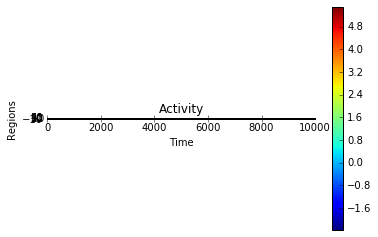

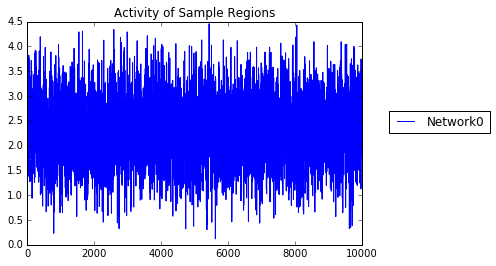

In [143]:
restdata, restbias = networkModel(Tmax=Tmaxrest,dt=dt,g=g,s=s,tau=1.0,I=None, noise=1, transfer='sigmoid', bias=bias)


### 2.1.1 Sample convolved resting-state timeseries

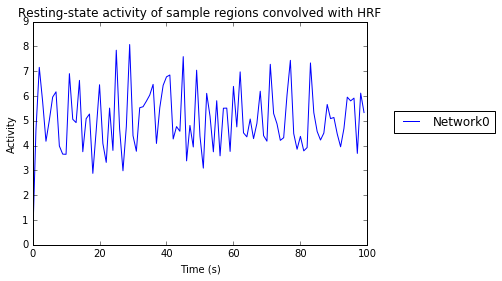

In [144]:
out1, out2 = convolveTimeseries(restdata, samplingrate=1.0, TRLength=100)
plt.figure()
plt.title('Resting-state activity of sample regions convolved with HRF')
for i in range(ncommunities):
    n = i * nodespernetwork
    plt.plot(out1[n,:], label='Network' + str(i))
plt.legend(loc=(1.08,.5))
plt.ylabel('Activity')
plt.xlabel('Time (s)')

### 2.1.2 Perform MultRegConn FC and visualize matrix

#### 2.1.2.1 Compare pre-convolved timeseries B0 with restbias

In [145]:
fc_multreg, rsquared = fc.multregressionconnectivity(restdata)
print 'Mean r-squared fit', np.mean(rsquared)
print 'Std r-squared fit', np.std(rsquared)
B0_multreg = np.diag(fc_multreg)
r, p = stats.pearsonr(restbias,B0_multreg)
print 'Pearson-r of B0s pre-convolved with biases:', r, '; p =' , p 

Mean r-squared fit 0.0238041044989
Std r-squared fit 0.0151491794279
Pearson-r of B0s pre-convolved with biases: 0.85413257738 ; p = 3.1242492692e-15


In [146]:
print 'Range of B0s'
print '\tmin =', np.min(B0_multreg)
print '\tmax =', np.max(B0_multreg)
print 'Range of rest biases'
print '\tmin =', np.min(restbias)
print '\tmax =', np.max(restbias)

Range of B0s
	min = -0.116437526755
	max = 3.04080787609
Range of rest biases
	min = -5
	max = 4


#### 2.1.2.2 Compare HRF-convolved timeseries B0 with restbias

In [147]:
fc_multreg_hrf, rsquared_hrf = fc.multregressionconnectivity(out1)
print 'Mean r-squared fit', np.mean(rsquared_hrf)
print 'Std r-squared fit', np.std(rsquared_hrf)
# plt.imshow(fc_multreg_hrf, origin='lower')
# plt.colorbar()
# plt.title('Visualize MultReg post-HRF')

Mean r-squared fit 0.531886274943
Std r-squared fit 0.0653255064671


In [148]:
B0_multreg_hrf = np.diag(fc_multreg_hrf)
r, p = stats.pearsonr(restbias,B0_multreg_hrf)
print 'Pearson-r of B0s after HRF convolved with biases:', r, '; p =', p 

Pearson-r of B0s after HRF convolved with biases: 0.459542324899 ; p = 0.000787388238699


In [149]:
print 'Range of B0s'
print '\tmin =', np.min(B0_multreg_hrf)
print '\tmax =', np.max(B0_multreg_hrf)
print 'Range of rest biases'
print '\tmin =', np.min(restbias)
print '\tmax =', np.max(restbias)

Range of B0s
	min = -0.67173512543
	max = 1.3313694415
Range of rest biases
	min = -5
	max = 4


## 2.1 Now model rest data with tanh function

/home/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


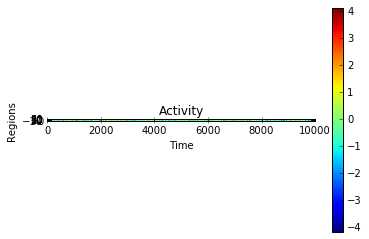

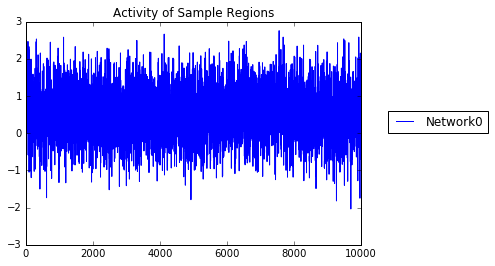

In [150]:
restdata, restbias = networkModel(Tmax=Tmaxrest,dt=dt,g=g,s=s,tau=1.0,I=None, noise=1, transfer='tanh', bias=bias)


### 2.1.1 Sample convolved resting-state timeseries

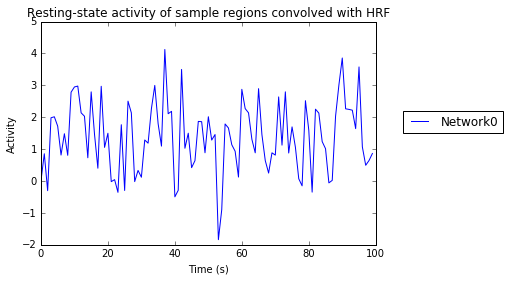

In [151]:
out1, out2 = convolveTimeseries(restdata, samplingrate=1.0, TRLength=100)
plt.figure()
plt.title('Resting-state activity of sample regions convolved with HRF')
for i in range(ncommunities):
    n = i * nodespernetwork
    plt.plot(out1[n,:], label='Network' + str(i))
plt.legend(loc=(1.08,.5))
plt.ylabel('Activity')
plt.xlabel('Time (s)')

### 2.1.2 Perform MultRegConn FC and visualize matrix

#### 2.1.2.1 Compare pre-convolved timeseries B0 with restbias

In [152]:
fc_multreg, rsquared = fc.multregressionconnectivity(restdata)
print 'Mean r-squared fit', np.mean(rsquared)
print 'Std r-squared fit', np.std(rsquared)
B0_multreg = np.diag(fc_multreg)
r, p = stats.pearsonr(restbias,B0_multreg)
print 'Pearson-r of B0s pre-convolved with biases:', r, '; p =' , p 

Mean r-squared fit 0.0241422221349
Std r-squared fit 0.0149176267626
Pearson-r of B0s pre-convolved with biases: 0.920125606664 ; p = 3.55912742319e-21


In [153]:
print 'Range of B0s'
print '\tmin =', np.min(B0_multreg)
print '\tmax =', np.max(B0_multreg)
print 'Range of rest biases'
print '\tmin =', np.min(restbias)
print '\tmax =', np.max(restbias)

Range of B0s
	min = -1.57297775398
	max = 1.35137627353
Range of rest biases
	min = -5
	max = 4


#### 2.1.2.2 Compare HRF-convolved timeseries B0 with restbias

Mean r-squared fit 0.740763110822
Std r-squared fit 0.262511752622


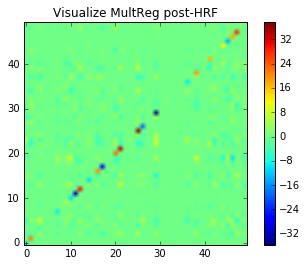

In [159]:
fc_multreg_hrf, rsquared_hrf = fc.multregressionconnectivity(out1)
print 'Mean r-squared fit', np.mean(rsquared_hrf)
print 'Std r-squared fit', np.std(rsquared_hrf)
plt.imshow(fc_multreg_hrf, origin='lower')
plt.colorbar()
plt.title('Visualize MultReg post-HRF')

In [155]:
B0_multreg_hrf = np.diag(fc_multreg_hrf)
r, p = stats.pearsonr(restbias,B0_multreg_hrf)
print 'Pearson-r of B0s after HRF convolved with biases:', r, '; p =', p 

Pearson-r of B0s after HRF convolved with biases: 0.695836130837 ; p = 2.03012927198e-08


In [156]:
print 'Range of B0s'
print '\tmin =', np.min(B0_multreg_hrf)
print '\tmax =', np.max(B0_multreg_hrf)
print 'Range of rest biases'
print '\tmin =', np.min(restbias)
print '\tmax =', np.max(restbias)

Range of B0s
	min = -1.55510364932
	max = 1.57782481729
Range of rest biases
	min = -5
	max = 4


## 2.3 Now model rest data with relu function

/home/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


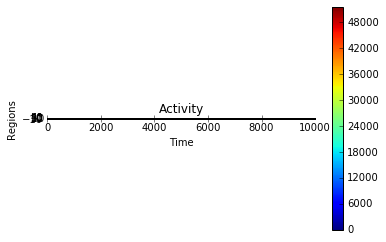

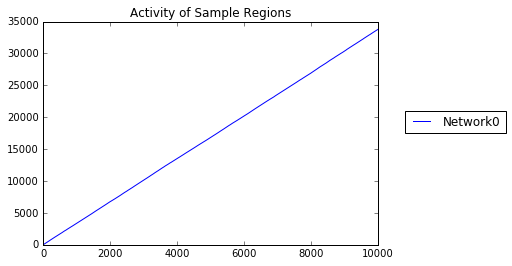

In [157]:
restdata, restbias = networkModel(Tmax=Tmaxrest,dt=dt,g=g,s=s,tau=1.0,I=None, noise=1, transfer='relu', bias=bias)


### 2.1.1 Sample convolved resting-state timeseries

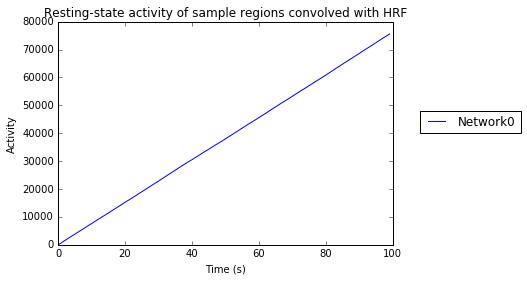

In [158]:
out1, out2 = convolveTimeseries(restdata, samplingrate=1.0, TRLength=100)
plt.figure()
plt.title('Resting-state activity of sample regions convolved with HRF')
for i in range(ncommunities):
    n = i * nodespernetwork
    plt.plot(out1[n,:], label='Network' + str(i))
plt.legend(loc=(1.08,.5))
plt.ylabel('Activity')
plt.xlabel('Time (s)')

### 2.1.2 Perform MultRegConn FC and visualize matrix

#### 2.1.2.1 Compare pre-convolved timeseries B0 with restbias

In [152]:
fc_multreg, rsquared = fc.multregressionconnectivity(restdata)
print 'Mean r-squared fit', np.mean(rsquared)
print 'Std r-squared fit', np.std(rsquared)
B0_multreg = np.diag(fc_multreg)
r, p = stats.pearsonr(restbias,B0_multreg)
print 'Pearson-r of B0s pre-convolved with biases:', r, '; p =' , p 

Mean r-squared fit 0.0241422221349
Std r-squared fit 0.0149176267626
Pearson-r of B0s pre-convolved with biases: 0.920125606664 ; p = 3.55912742319e-21


In [153]:
print 'Range of B0s'
print '\tmin =', np.min(B0_multreg)
print '\tmax =', np.max(B0_multreg)
print 'Range of rest biases'
print '\tmin =', np.min(restbias)
print '\tmax =', np.max(restbias)

Range of B0s
	min = -1.57297775398
	max = 1.35137627353
Range of rest biases
	min = -5
	max = 4


#### 2.1.2.2 Compare HRF-convolved timeseries B0 with restbias

In [154]:
fc_multreg_hrf, rsquared_hrf = fc.multregressionconnectivity(out1)
print 'Mean r-squared fit', np.mean(rsquared_hrf)
print 'Std r-squared fit', np.std(rsquared_hrf)
# plt.imshow(fc_multreg_hrf, origin='lower')
# plt.colorbar()
# plt.title('Visualize MultReg post-HRF')

Mean r-squared fit 0.507105237266
Std r-squared fit 0.0684880130523


In [155]:
B0_multreg_hrf = np.diag(fc_multreg_hrf)
r, p = stats.pearsonr(restbias,B0_multreg_hrf)
print 'Pearson-r of B0s after HRF convolved with biases:', r, '; p =', p 

Pearson-r of B0s after HRF convolved with biases: 0.695836130837 ; p = 2.03012927198e-08


In [156]:
print 'Range of B0s'
print '\tmin =', np.min(B0_multreg_hrf)
print '\tmax =', np.max(B0_multreg_hrf)
print 'Range of rest biases'
print '\tmin =', np.min(restbias)
print '\tmax =', np.max(restbias)

Range of B0s
	min = -1.55510364932
	max = 1.57782481729
Range of rest biases
	min = -5
	max = 4


___

___

___

___